In [7]:
import Bio.SeqIO

In [66]:
with open("../data/hg38.gb") as handle:
    for record in Bio.SeqIO.parse(handle, 'genbank'):
        print("record:", record.id)
        #print("dir:", dir(record))

record: NC_000017.11


In [104]:
assembly_location = 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/215/GCF_000001215.4_Release_6_plus_ISO1_MT/GCF_000001215.4_Release_6_plus_ISO1_MT_assembly_report.txt'
#wget -O /tmp/assembly.txt ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/GCF_000001405.33_GRCh38.p7/GCF_000001405.33_GRCh38.p7_assembly_report.txt
!wget -O /tmp/assembly.txt {assembly_location}

--2018-01-03 16:16:35--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/215/GCF_000001215.4_Release_6_plus_ISO1_MT/GCF_000001215.4_Release_6_plus_ISO1_MT_assembly_report.txt
           => ‘/tmp/assembly.txt’
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.10, 2607:f220:41e:250::11
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCF/000/001/215/GCF_000001215.4_Release_6_plus_ISO1_MT ... done.
==> SIZE GCF_000001215.4_Release_6_plus_ISO1_MT_assembly_report.txt ... 214085
==> PASV ... done.    ==> RETR GCF_000001215.4_Release_6_plus_ISO1_MT_assembly_report.txt ... done.
Length: 214085 (209K) (unauthoritative)

GCF_000001215.4_Rel 100%[===================>] 209.07K  --.-KB/s    in 0.09s   

2018-01-03 16:16:35 (2.29 MB/s) - ‘/tmp/assembly.txt’ saved [214085]



In [106]:
%%bash

cat /tmp/assembly.txt | grep "^#" | tail -n 1 > /tmp/assembly_headers.txt
cat /tmp/assembly.txt | grep -v "^#" > /tmp/assembly_processed.txt

In [109]:
print(op.basename(assembly_location))

GCF_000001215.4_Release_6_plus_ISO1_MT_assembly_report.txt


In [92]:
with open('/tmp/assembly_headers.txt', 'r') as f:
    headers = f.readlines()[0].strip().split()[1:]
    print(headers)

['Sequence-Name', 'Sequence-Role', 'Assigned-Molecule', 'Assigned-Molecule-Location/Type', 'GenBank-Accn', 'Relationship', 'RefSeq-Accn', 'Assembly-Unit', 'Sequence-Length', 'UCSC-style-name']


In [103]:
import urllib
import os
import os.path as op

output_dir = op.expanduser('~/data/genbank/nuccore')

if not op.exists(output_dir):
    os.makedirs(output_dir)

with open('/tmp/assembly_processed.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        genbank_accn = parts[4]
        sequence_name = parts[0]
        
        output_file  = op.join(output_dir, '{}.gb'.format(genbank_accn))
        done_file = '{}.done'.format(output_file)
        
        print(output_file)
        
        if not op.exists(done_file):
            try:
                urllib.request.urlretrieve('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nuccore&id={}&rettype=gbwithparts'
                               .format(genbank_accn), output_file)
                with open(done_file, 'w') as f1:
                    pass
            except Exception as ex:
                print('Ex:', ex)

/Users/peter/data/genbank/nuccore/AE014298.5.gb
/Users/peter/data/genbank/nuccore/AE014134.6.gb
/Users/peter/data/genbank/nuccore/AE013599.5.gb
/Users/peter/data/genbank/nuccore/AE014296.5.gb
/Users/peter/data/genbank/nuccore/AE014297.3.gb
/Users/peter/data/genbank/nuccore/AE014135.4.gb
/Users/peter/data/genbank/nuccore/CP007106.1.gb
/Users/peter/data/genbank/nuccore/CP007103.1.gb
/Users/peter/data/genbank/nuccore/CP007104.1.gb
/Users/peter/data/genbank/nuccore/DS483648.1.gb
/Users/peter/data/genbank/nuccore/DS483655.1.gb
/Users/peter/data/genbank/nuccore/DS483660.1.gb
/Users/peter/data/genbank/nuccore/DS483665.1.gb
/Users/peter/data/genbank/nuccore/DS483666.1.gb
/Users/peter/data/genbank/nuccore/DS483669.1.gb
/Users/peter/data/genbank/nuccore/DS483685.1.gb
/Users/peter/data/genbank/nuccore/DS483698.1.gb
/Users/peter/data/genbank/nuccore/DS483745.1.gb
/Users/peter/data/genbank/nuccore/DS483784.1.gb
/Users/peter/data/genbank/nuccore/DS483789.1.gb
/Users/peter/data/genbank/nuccore/DS4837

/Users/peter/data/genbank/nuccore/DS484497.1.gb
/Users/peter/data/genbank/nuccore/DS484500.1.gb
/Users/peter/data/genbank/nuccore/DS484504.1.gb
/Users/peter/data/genbank/nuccore/DS484506.1.gb
/Users/peter/data/genbank/nuccore/DS484507.1.gb
/Users/peter/data/genbank/nuccore/DS484512.1.gb
/Users/peter/data/genbank/nuccore/DS484518.1.gb
/Users/peter/data/genbank/nuccore/DS484519.1.gb
/Users/peter/data/genbank/nuccore/DS484526.1.gb
/Users/peter/data/genbank/nuccore/DS484529.1.gb
/Users/peter/data/genbank/nuccore/DS484533.1.gb
/Users/peter/data/genbank/nuccore/DS484535.1.gb
/Users/peter/data/genbank/nuccore/DS484538.1.gb
/Users/peter/data/genbank/nuccore/DS484540.1.gb
/Users/peter/data/genbank/nuccore/DS484541.1.gb
/Users/peter/data/genbank/nuccore/DS484545.1.gb
/Users/peter/data/genbank/nuccore/DS484547.1.gb
/Users/peter/data/genbank/nuccore/DS484552.1.gb
/Users/peter/data/genbank/nuccore/DS484555.1.gb
/Users/peter/data/genbank/nuccore/DS484556.1.gb
/Users/peter/data/genbank/nuccore/DS4845

/Users/peter/data/genbank/nuccore/DS485110.1.gb
/Users/peter/data/genbank/nuccore/DS485111.1.gb
/Users/peter/data/genbank/nuccore/DS485112.1.gb
/Users/peter/data/genbank/nuccore/DS485119.1.gb
/Users/peter/data/genbank/nuccore/DS485126.1.gb
/Users/peter/data/genbank/nuccore/DS485141.1.gb
/Users/peter/data/genbank/nuccore/DS485164.1.gb
/Users/peter/data/genbank/nuccore/DS485167.1.gb
/Users/peter/data/genbank/nuccore/DS485172.1.gb
/Users/peter/data/genbank/nuccore/DS485186.1.gb
/Users/peter/data/genbank/nuccore/DS485189.1.gb
/Users/peter/data/genbank/nuccore/DS485195.1.gb
/Users/peter/data/genbank/nuccore/DS485201.1.gb
/Users/peter/data/genbank/nuccore/DS485225.1.gb
/Users/peter/data/genbank/nuccore/DS485235.1.gb
/Users/peter/data/genbank/nuccore/DS485238.1.gb
/Users/peter/data/genbank/nuccore/DS485257.1.gb
/Users/peter/data/genbank/nuccore/DS485262.1.gb
/Users/peter/data/genbank/nuccore/DS485266.1.gb
/Users/peter/data/genbank/nuccore/DS485268.1.gb
/Users/peter/data/genbank/nuccore/DS4852

/Users/peter/data/genbank/nuccore/DS484523.1.gb
/Users/peter/data/genbank/nuccore/DS484530.1.gb
/Users/peter/data/genbank/nuccore/DS484531.1.gb
/Users/peter/data/genbank/nuccore/DS484574.1.gb
/Users/peter/data/genbank/nuccore/DS484589.1.gb
/Users/peter/data/genbank/nuccore/DS484631.1.gb
/Users/peter/data/genbank/nuccore/DS484637.1.gb
/Users/peter/data/genbank/nuccore/DS484641.1.gb
/Users/peter/data/genbank/nuccore/DS484643.1.gb
/Users/peter/data/genbank/nuccore/DS484665.1.gb
/Users/peter/data/genbank/nuccore/DS484674.1.gb
/Users/peter/data/genbank/nuccore/DS484675.1.gb
/Users/peter/data/genbank/nuccore/DS484680.1.gb
/Users/peter/data/genbank/nuccore/DS484681.1.gb
/Users/peter/data/genbank/nuccore/DS484696.1.gb
/Users/peter/data/genbank/nuccore/DS484706.1.gb
/Users/peter/data/genbank/nuccore/DS484757.1.gb
/Users/peter/data/genbank/nuccore/DS484781.1.gb
/Users/peter/data/genbank/nuccore/DS484805.1.gb
/Users/peter/data/genbank/nuccore/DS484807.1.gb
/Users/peter/data/genbank/nuccore/DS4848

/Users/peter/data/genbank/nuccore/CP007105.1.gb
/Users/peter/data/genbank/nuccore/CP007120.1.gb
/Users/peter/data/genbank/nuccore/DS483562.1.gb
/Users/peter/data/genbank/nuccore/DS483629.1.gb
/Users/peter/data/genbank/nuccore/DS483641.1.gb
/Users/peter/data/genbank/nuccore/DS483646.1.gb
/Users/peter/data/genbank/nuccore/DS483647.1.gb
/Users/peter/data/genbank/nuccore/DS483649.1.gb
/Users/peter/data/genbank/nuccore/DS483650.1.gb
/Users/peter/data/genbank/nuccore/DS483658.1.gb
/Users/peter/data/genbank/nuccore/DS483659.1.gb
/Users/peter/data/genbank/nuccore/DS483662.1.gb
/Users/peter/data/genbank/nuccore/DS483663.1.gb
/Users/peter/data/genbank/nuccore/DS483670.1.gb
/Users/peter/data/genbank/nuccore/DS483673.1.gb
/Users/peter/data/genbank/nuccore/DS483674.1.gb
/Users/peter/data/genbank/nuccore/DS483675.1.gb
/Users/peter/data/genbank/nuccore/DS483678.1.gb
/Users/peter/data/genbank/nuccore/DS483679.1.gb
/Users/peter/data/genbank/nuccore/DS483680.1.gb
/Users/peter/data/genbank/nuccore/DS4836

/Users/peter/data/genbank/nuccore/DS483938.1.gb
/Users/peter/data/genbank/nuccore/DS483939.1.gb
/Users/peter/data/genbank/nuccore/DS483940.1.gb
/Users/peter/data/genbank/nuccore/DS483941.1.gb
/Users/peter/data/genbank/nuccore/DS483943.1.gb
/Users/peter/data/genbank/nuccore/DS483944.1.gb
/Users/peter/data/genbank/nuccore/DS483945.1.gb
/Users/peter/data/genbank/nuccore/DS483947.1.gb
/Users/peter/data/genbank/nuccore/DS483949.1.gb
/Users/peter/data/genbank/nuccore/DS483951.1.gb
/Users/peter/data/genbank/nuccore/DS483953.1.gb
/Users/peter/data/genbank/nuccore/DS483954.1.gb
/Users/peter/data/genbank/nuccore/DS483956.1.gb
/Users/peter/data/genbank/nuccore/DS483957.1.gb
/Users/peter/data/genbank/nuccore/DS483960.1.gb
/Users/peter/data/genbank/nuccore/DS483961.1.gb
/Users/peter/data/genbank/nuccore/DS483964.1.gb
/Users/peter/data/genbank/nuccore/DS483965.1.gb
/Users/peter/data/genbank/nuccore/DS483970.1.gb
/Users/peter/data/genbank/nuccore/DS483972.1.gb
/Users/peter/data/genbank/nuccore/DS4839

/Users/peter/data/genbank/nuccore/DS484251.1.gb
/Users/peter/data/genbank/nuccore/DS484253.1.gb
/Users/peter/data/genbank/nuccore/DS484254.1.gb
/Users/peter/data/genbank/nuccore/DS484255.1.gb
/Users/peter/data/genbank/nuccore/DS484256.1.gb
/Users/peter/data/genbank/nuccore/DS484257.1.gb
/Users/peter/data/genbank/nuccore/DS484258.1.gb
/Users/peter/data/genbank/nuccore/DS484262.1.gb
/Users/peter/data/genbank/nuccore/DS484263.1.gb
/Users/peter/data/genbank/nuccore/DS484264.1.gb
/Users/peter/data/genbank/nuccore/DS484267.1.gb
/Users/peter/data/genbank/nuccore/DS484271.1.gb
/Users/peter/data/genbank/nuccore/DS484274.1.gb
/Users/peter/data/genbank/nuccore/DS484275.1.gb
/Users/peter/data/genbank/nuccore/DS484276.1.gb
/Users/peter/data/genbank/nuccore/DS484277.1.gb
/Users/peter/data/genbank/nuccore/DS484279.1.gb
/Users/peter/data/genbank/nuccore/DS484280.1.gb
/Users/peter/data/genbank/nuccore/DS484281.1.gb
/Users/peter/data/genbank/nuccore/DS484282.1.gb
/Users/peter/data/genbank/nuccore/DS4842

/Users/peter/data/genbank/nuccore/DS484593.1.gb
/Users/peter/data/genbank/nuccore/DS484595.1.gb
/Users/peter/data/genbank/nuccore/DS484601.1.gb
/Users/peter/data/genbank/nuccore/DS484602.1.gb
/Users/peter/data/genbank/nuccore/DS484606.1.gb
/Users/peter/data/genbank/nuccore/DS484607.1.gb
/Users/peter/data/genbank/nuccore/DS484614.1.gb
/Users/peter/data/genbank/nuccore/DS484616.1.gb
/Users/peter/data/genbank/nuccore/DS484617.1.gb
/Users/peter/data/genbank/nuccore/DS484619.1.gb
/Users/peter/data/genbank/nuccore/DS484621.1.gb
/Users/peter/data/genbank/nuccore/DS484629.1.gb
/Users/peter/data/genbank/nuccore/DS484630.1.gb
/Users/peter/data/genbank/nuccore/DS484632.1.gb
/Users/peter/data/genbank/nuccore/DS484635.1.gb
/Users/peter/data/genbank/nuccore/DS484639.1.gb
/Users/peter/data/genbank/nuccore/DS484642.1.gb
/Users/peter/data/genbank/nuccore/DS484646.1.gb
/Users/peter/data/genbank/nuccore/DS484649.1.gb
/Users/peter/data/genbank/nuccore/DS484651.1.gb
/Users/peter/data/genbank/nuccore/DS4846

/Users/peter/data/genbank/nuccore/DS484993.1.gb
/Users/peter/data/genbank/nuccore/DS484998.1.gb
/Users/peter/data/genbank/nuccore/DS484999.1.gb
/Users/peter/data/genbank/nuccore/DS485000.1.gb
/Users/peter/data/genbank/nuccore/DS485002.1.gb
/Users/peter/data/genbank/nuccore/DS485004.1.gb
/Users/peter/data/genbank/nuccore/DS485005.1.gb
/Users/peter/data/genbank/nuccore/DS485007.1.gb
/Users/peter/data/genbank/nuccore/DS485010.1.gb
/Users/peter/data/genbank/nuccore/DS485011.1.gb
/Users/peter/data/genbank/nuccore/DS485019.1.gb
/Users/peter/data/genbank/nuccore/DS485020.1.gb
/Users/peter/data/genbank/nuccore/DS485022.1.gb
/Users/peter/data/genbank/nuccore/DS485024.1.gb
/Users/peter/data/genbank/nuccore/DS485025.1.gb
/Users/peter/data/genbank/nuccore/DS485026.1.gb
/Users/peter/data/genbank/nuccore/DS485027.1.gb
/Users/peter/data/genbank/nuccore/DS485029.1.gb
/Users/peter/data/genbank/nuccore/DS485030.1.gb
/Users/peter/data/genbank/nuccore/DS485031.1.gb
/Users/peter/data/genbank/nuccore/DS4850

/Users/peter/data/genbank/nuccore/DS485338.1.gb
/Users/peter/data/genbank/nuccore/DS485339.1.gb
/Users/peter/data/genbank/nuccore/DS485340.1.gb
/Users/peter/data/genbank/nuccore/DS485341.1.gb
/Users/peter/data/genbank/nuccore/DS485342.1.gb
/Users/peter/data/genbank/nuccore/DS485349.1.gb
/Users/peter/data/genbank/nuccore/DS485353.1.gb
/Users/peter/data/genbank/nuccore/DS485354.1.gb
/Users/peter/data/genbank/nuccore/DS485356.1.gb
/Users/peter/data/genbank/nuccore/DS485357.1.gb
/Users/peter/data/genbank/nuccore/DS485361.1.gb
/Users/peter/data/genbank/nuccore/DS485362.1.gb
/Users/peter/data/genbank/nuccore/DS485365.1.gb
/Users/peter/data/genbank/nuccore/DS485368.1.gb
/Users/peter/data/genbank/nuccore/DS485370.1.gb
/Users/peter/data/genbank/nuccore/DS485371.1.gb
/Users/peter/data/genbank/nuccore/DS485376.1.gb
/Users/peter/data/genbank/nuccore/DS485379.1.gb
/Users/peter/data/genbank/nuccore/DS485381.1.gb
/Users/peter/data/genbank/nuccore/DS485382.1.gb
/Users/peter/data/genbank/nuccore/DS4853

/Users/peter/data/genbank/nuccore/DS485673.1.gb
/Users/peter/data/genbank/nuccore/DS485675.1.gb
/Users/peter/data/genbank/nuccore/DS485678.1.gb
/Users/peter/data/genbank/nuccore/DS485679.1.gb
/Users/peter/data/genbank/nuccore/DS485681.1.gb
/Users/peter/data/genbank/nuccore/DS485682.1.gb
/Users/peter/data/genbank/nuccore/DS485683.1.gb
/Users/peter/data/genbank/nuccore/DS485684.1.gb
/Users/peter/data/genbank/nuccore/DS485686.1.gb
/Users/peter/data/genbank/nuccore/DS485688.1.gb
/Users/peter/data/genbank/nuccore/DS485692.1.gb
/Users/peter/data/genbank/nuccore/DS485693.1.gb
/Users/peter/data/genbank/nuccore/DS485694.1.gb
/Users/peter/data/genbank/nuccore/DS485695.2.gb
/Users/peter/data/genbank/nuccore/DS485701.1.gb
/Users/peter/data/genbank/nuccore/DS485703.1.gb
/Users/peter/data/genbank/nuccore/DS485709.1.gb
/Users/peter/data/genbank/nuccore/DS485711.1.gb
/Users/peter/data/genbank/nuccore/DS485712.1.gb
/Users/peter/data/genbank/nuccore/DS485714.1.gb
/Users/peter/data/genbank/nuccore/DS4857

In [65]:
genes = []

def parse_location(location_str):
    return location_str.split('..')

def parse_string(location_str):
    if location_str.index('complement') == 0:
        return '-'
    else:
        return '+'

count = 0
genes = {}
ncRNAs = []

def parse_entity(feature):
    '''
    Parse a transcribed entity
    '''
    entity = {}
    # print('feature:', feature)
    
    entity['start'] = feature.location.start.position
    entity['end'] = feature.location.end.position
    entity['strand'] = '+' if feature.location.strand == 1 else '-'
    #print(dir(feature))
    #print("qulaifiers:", feature.qualifiers)
    if 'gene' in feature.qualifiers:
        entity['name'] = feature.qualifiers['gene'][0]
    
    
    for part in feature.location.parts:
        entity['location_parts'] = {
            'start': part.start.position,
            'end': part.end.position,
            'strand': '+' if part.strand == 1 else '-',
        }

    for xref in feature.qualifiers['db_xref']:
        parts = xref.split(':')
        if parts[0] == 'GeneID':
            entity['geneId'] = parts[1]
            break

    if 'transcript_id' in feature.qualifiers:
        entity['transcriptId'] = feature.qualifiers['transcript_id'][0]

    #print('entity:', entity)
    return entity

for feature in record.features:
    # print("dir", dir(feature))
    # print(feature.type)
    # print(feature.location, type(feature.location))
    # print(dir(feature))
    curr_entity = parse_entity(feature)
    curr_entity['type'] = feature.type
    
    if feature.type == 'gene':
        curr_entity['mRNAs'] = []
        genes[curr_entity['geneId']] = curr_entity
        
        if 'pseudo' in feature.qualifiers:
            curr_entity['type'] = 'pseudo'
        
        # print("gene", curr_entity)
    elif feature.type == 'CDS':
        #print("feature:", feature)

        cds = {}
        cds['start'] = feature.location.start.position
        cds['end'] = feature.location.end.position
        genes[curr_entity['geneId']]['cds'] = cds
    elif feature.type == 'ncRNA':
        genes[curr_entity['geneId']] = curr_entity
    elif feature.type == 'mRNA':
        if 'mRNAs' not in genes[curr_entity['geneId']]:
            genes[curr_entity['geneId']]['mRNAs'] = []
        genes[curr_entity['geneId']]['mRNAs'] += [curr_entity]
    elif feature.type == 'misc_RNA':
        genes[curr_entity['geneId']] = curr_entity        
        #print(feature)
    elif feature.type == 'precursor_RNA':
        genes[curr_entity['geneId']] = curr_entity
    elif feature.type == 'tRNA':
        genes[curr_entity['geneId']] = curr_entity
    else:
        print(feature)
        
    count += 1

import json
with open('/tmp/out.json', 'w') as f:
    json.dump(genes, f, indent=2)
print("count:", count)

type: source
location: [0:83257441](+)
qualifiers:
    Key: chromosome, Value: ['17']
    Key: db_xref, Value: ['taxon:9606']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Homo sapiens']

count: 16605


Bio.__version__

In [12]:
dir(feature)

['__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_flip',
 '_get_location_operator',
 '_get_ref',
 '_get_ref_db',
 '_get_strand',
 '_set_location_operator',
 '_set_ref',
 '_set_ref_db',
 '_set_strand',
 '_shift',
 'extract',
 'id',
 'location',
 'location_operator',
 'qualifiers',
 'ref',
 'ref_db',
 'strand',
 'type']

In [70]:
a = [25, 33, 47, 53, 62, 64, 78, 86, 99, 144, 164, 217, 219, 222, 240, 257, 356]

In [75]:
%matplotlib inline

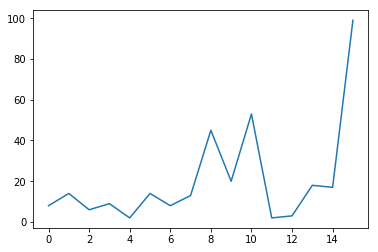

In [77]:
import matplotlib.pyplot as plt

plt.plot(range(len(a)-1), [a[i+1] - a[i] for i in range(len(a)-1)])